<h1 align="center">Facial Recognition experimentation</h1>

In [1]:
import numpy as np
from os import walk
from scipy.misc import imread
from scipy import linalg as la

from matplotlib import pyplot as plt, rcParams
%matplotlib inline

### Helper Functions

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, flatten=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, flatten=True))

## Displaying a face from the dataset

In [3]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    plt.imshow(image.reshape((m, n)), cmap='gray')
    plt.axis('off')
    plt.show()

/home/kylrth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


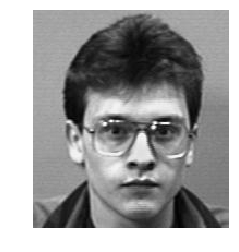

In [4]:
# Show a face from the faces94 dataset.
face = get_faces().T[100]
show(face)


## Facial Recognition Class

In [5]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        faces (ndarray): 2-D array containing images as columns of length m*n
        mean_face (ndarray): 1-D vector containing image of mean face
        mean_shifted (ndarray): 2-D array containing images from faces, with the mean face subtracted
        eigenfaces (ndarray): U from the SVD decomposition of mean_shifted
    """
    def __init__(self, path='./faces94'):
        """Initialize all attributes.
        This is the main part of the computation.
        """
        self.faces = get_faces()
        self.mean_face = self.faces.sum(axis=1) / len(self.faces[0])
        self.mean_shifted = self.faces - self.mean_face[:, np.newaxis]
        self.eigenfaces = la.svd(self.mean_shifted, full_matrices=False)[0]

    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.eigenfaces[:, :s].T @ A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        g_hat = self.project(g - self.mean_face, s)
        F_hat = self.project(self.mean_shifted, s)
        return np.argmin(la.norm(F_hat - g_hat[:, np.newaxis], axis=0))

## The mean face

The mean face isn't angry, it's the average of all the images in the dataset.

/home/kylrth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


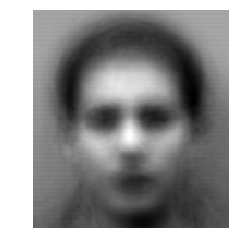

In [6]:
# Display the mean face.
thing = FacialRec()
show(thing.mean_face)

A mean-shifted face is the image after having subtracted the mean face.

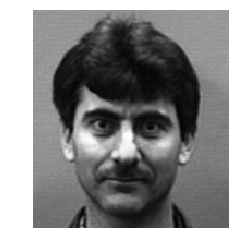

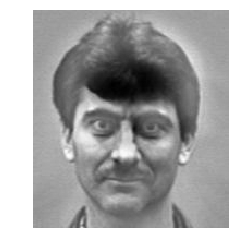

In [7]:
# Display an image along with its mean-shifted face.
show(thing.faces.T[101])
show(thing.mean_shifted.T[101])

## Eigenfaces

We could compare a test image to all other images in the dataset and find the one that minimizes the L2-norm, but that would be computationally expensive. Instead, we compute "eigenfaces": face images which are projected onto a lower-dimensional space using the SVD (singular-value decomposition).

First:


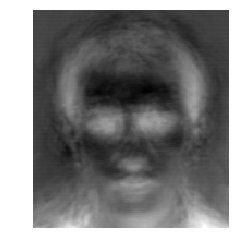

Fiftieth:


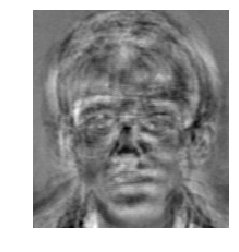

Eightieth


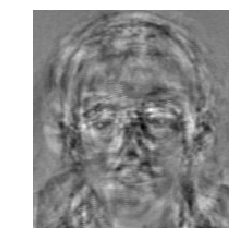

120th:


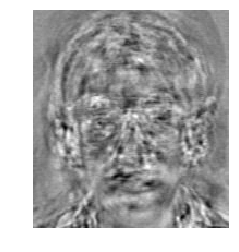

In [8]:
# Display some of the eigenfaces.
print('First:')
show(thing.eigenfaces.T[0])
print('Fiftieth:')
show(thing.eigenfaces.T[49])
print('Eightieth')
show(thing.eigenfaces.T[79])
print('120th:')
show(thing.eigenfaces.T[119])

Each image can then be reconstructed from eigenfaces as seen below.

Original:


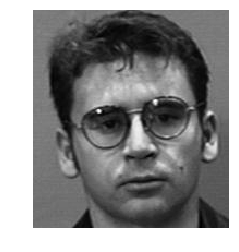

s = 5:


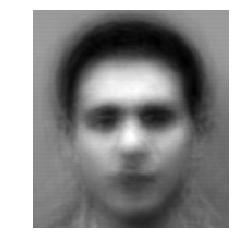

s = 20:


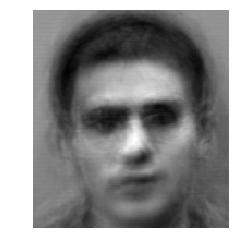

s = 50:


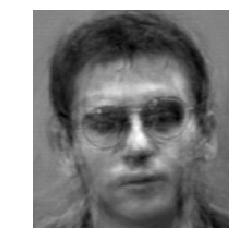

s = 80:


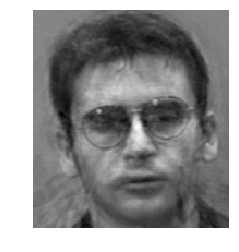

In [9]:
# Display a face image reconstructed with various numbers of eigenfaces.
choice = 87
shifted_face = thing.mean_shifted.T[choice]
print('Original:')
show(thing.faces.T[choice])
for s in [5, 20, 50, 80]:
    print('s = ' + str(s) + ':')
    show(thing.eigenfaces[:, :s] @ thing.project(shifted_face, s) + thing.mean_face)

## Recognizing faces

The `find_nearest` method of the `FacialRecognition` class compares a sample image with the space of the first `s` eigenfaces to determine which image from the training set is closest. In this way, similar faces can be recognized. Note how the images below, while not identical, contain the same face.

Test 1:


/home/kylrth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


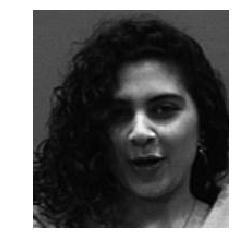

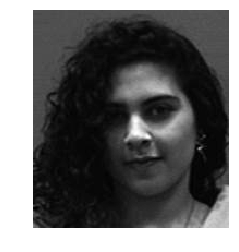

Test 2:


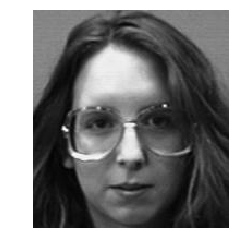

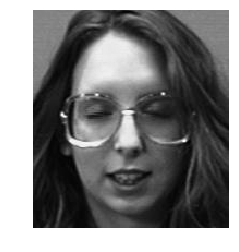

Test 3:


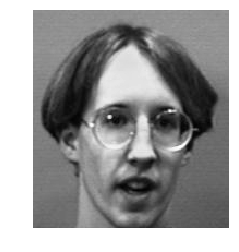

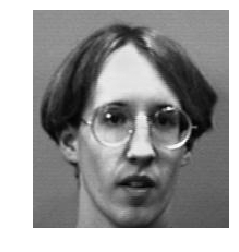

Test 4:


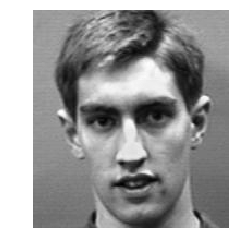

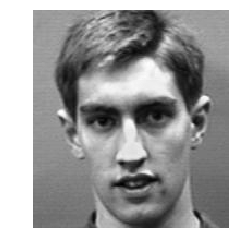

Test 5:


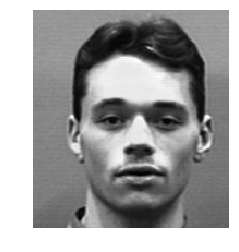

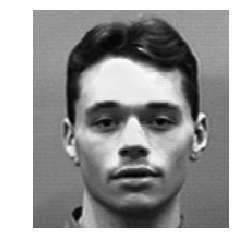

In [10]:
# Display some random images along with their closest match.
count = 1
for test_face in sample_faces(5):
    print('Test ' + str(count) + ':')
    count += 1
    show(test_face)
    show(thing.faces.T[thing.find_nearest(test_face)])